In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import requests
import tensorflow_datasets as tfds
from tqdm import tqdm
import os
import shutil
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout


import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

# DATA Visualization 


In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = '../input/image-super-resolution/dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = '../input/image-super-resolution/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '855.jpg':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:07<00:00, 117.35it/s]


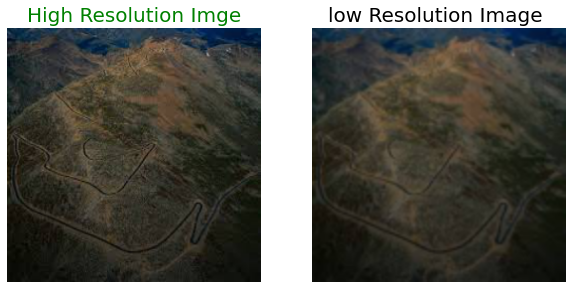

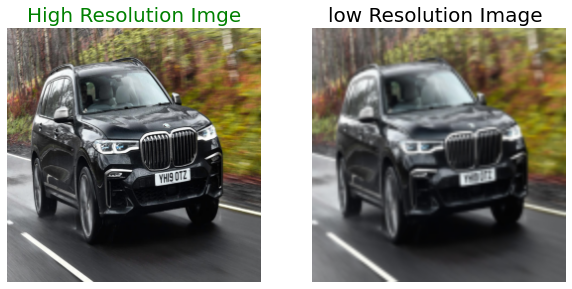

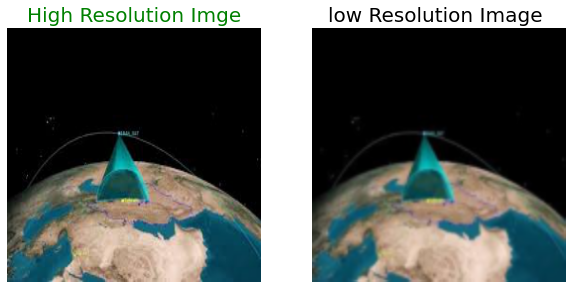

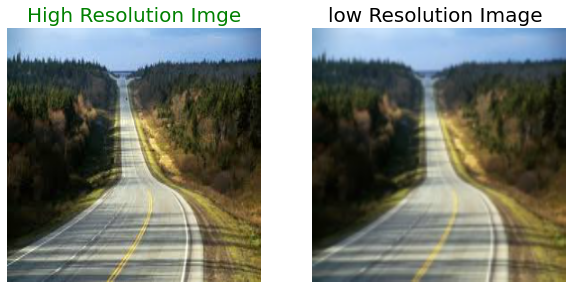

In [3]:
for i in range(4):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')


split data into Train , validation and test Data 

In [4]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)



Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
def residual_block_gen(ch=64,k_s=3,st=1):
    model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),])
    return model

def Upsample_block(x,ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x
lr=tf.keras.layers.Input(shape=(256,256,3))
input_conv=tf.keras.layers.Conv2D(64,9,padding='same')(lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

def model():
    SRRes=input_conv
    for x in range(5):
        res_output=residual_block_gen()(SRRes)
        SRRes=Upsample_block(SRRes)
        SRRes=MaxPooling2D()(SRRes)
        SRRes=tf.keras.layers.Add()([SRRes,res_output])
        SRRes=tf.keras.layers.Conv2D(64,9,padding='same')(SRRes)
    SRRes=tf.keras.layers.BatchNormalization()(SRRes)
    SRRes=tf.keras.layers.Add()([SRRes,input_conv])
    SRRes=Upsample_block(SRRes)
    SRRes=MaxPooling2D()(SRRes)
    #SRRes=Upsample_block(SRRes)
    #SRRes=downsample_image(SRRes,4)
    #SRRes=Upsample_block(SRRes)
    output_sr=tf.keras.layers.Conv2D(3,9,activation='sigmoid',padding='same')(SRRes)
    return tf.keras.models.Model(lr,output_sr)

2022-11-06 11:04:48.149432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 11:04:48.279525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 11:04:48.280374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 11:04:48.282029: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 15616       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 256 147712      leaky_re_lu[0][0]                
______________________________________________________________________________________________

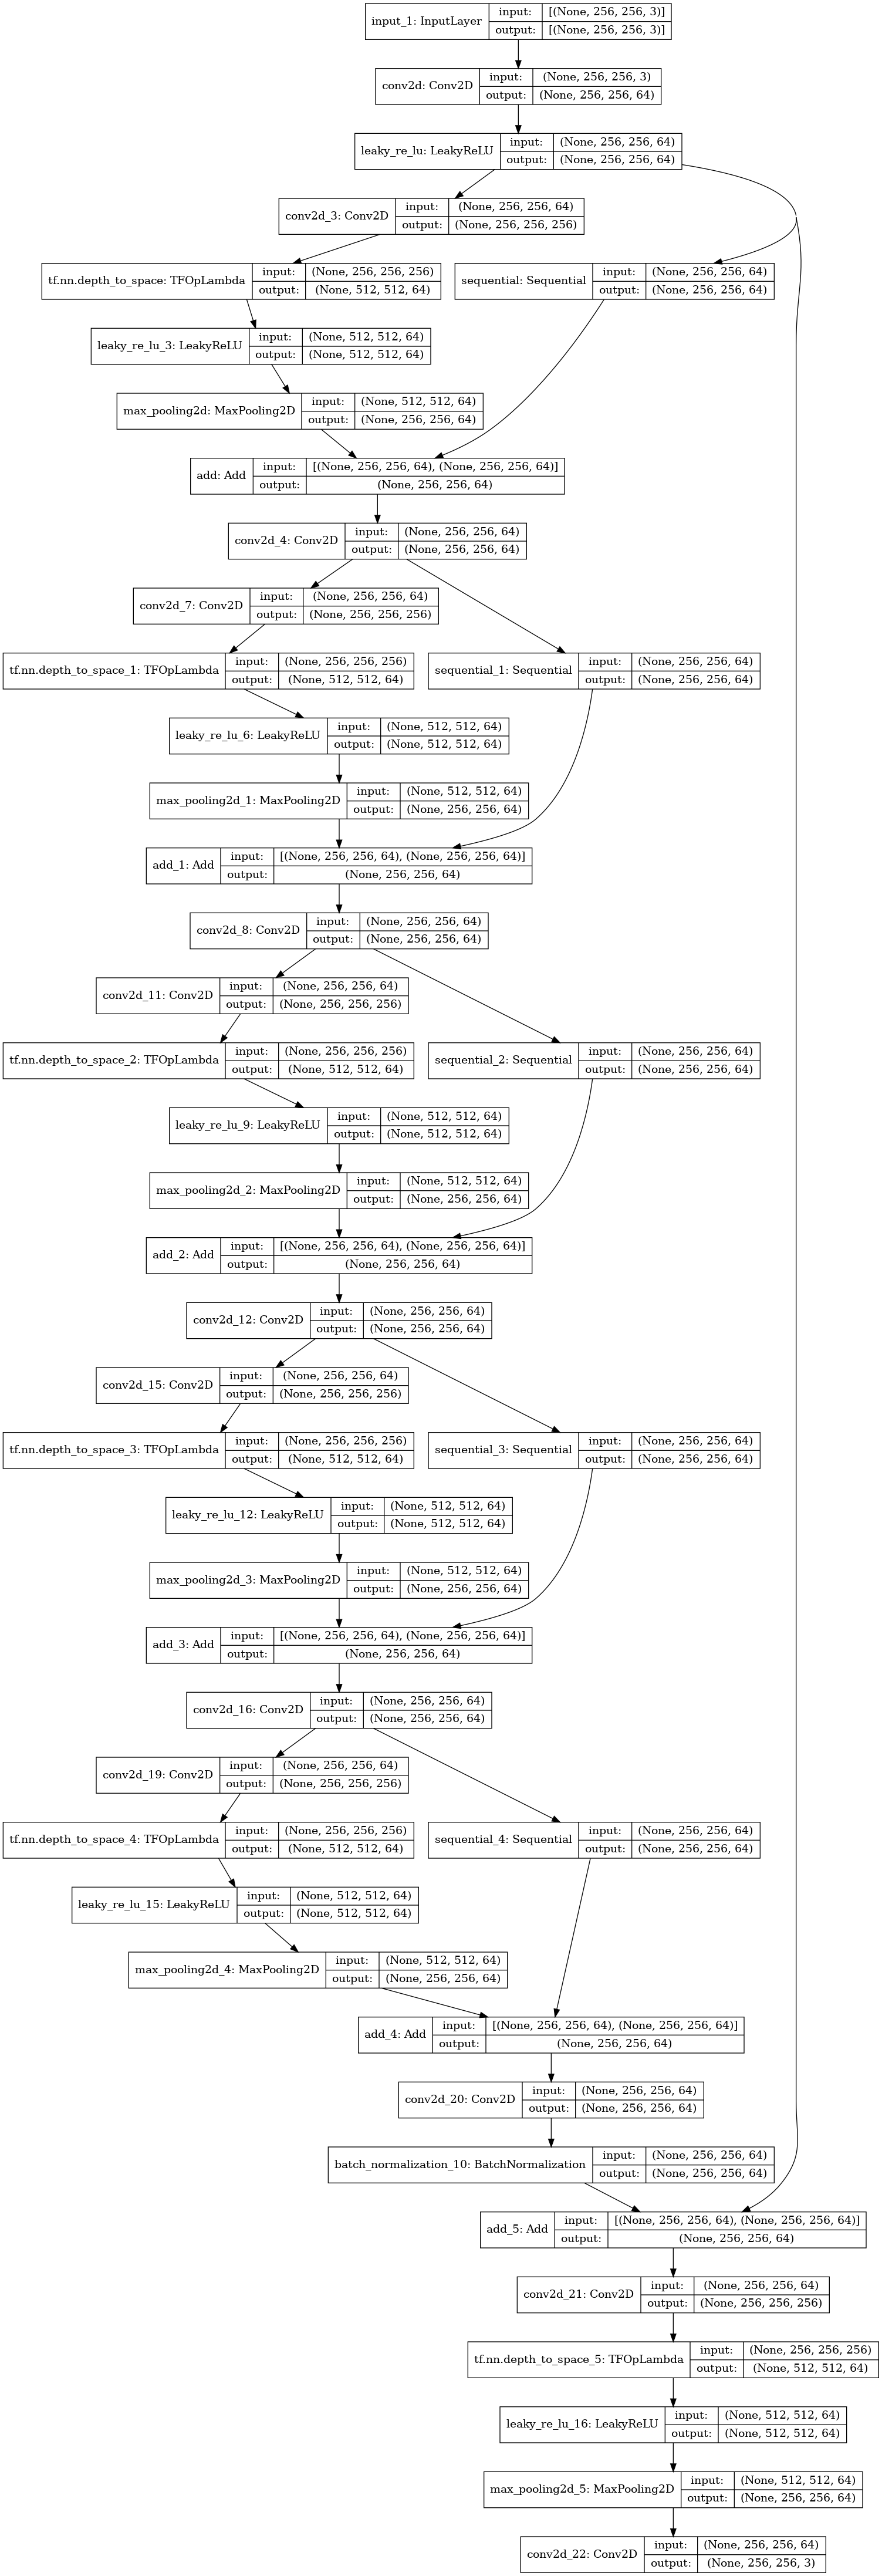

In [6]:
model = model()
model.summary()
plot_model(model, to_file ='super_res.png',show_shapes=True)

In [7]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [8]:
history = model.fit(train_low_image, train_high_image, epochs = 10, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

2022-11-06 11:04:54.788021: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-11-06 11:04:57.121295: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


700/700 [==============================] - 167s 227ms/step - loss: 0.1262 - acc: 0.4981 - val_loss: 0.0965 - val_acc: 0.5132
Epoch 2/10
700/700 [==============================] - 155s 222ms/step - loss: 0.0955 - acc: 0.5199 - val_loss: 0.0744 - val_acc: 0.6705
Epoch 3/10
700/700 [==============================] - 155s 222ms/step - loss: 0.0561 - acc: 0.6335 - val_loss: 0.0515 - val_acc: 0.6628
Epoch 4/10
700/700 [==============================] - 158s 225ms/step - loss: 0.0430 - acc: 0.6894 - val_loss: 0.0389 - val_acc: 0.7932
Epoch 5/10
700/700 [==============================] - 158s 225ms/step - loss: 0.0409 - acc: 0.6897 - val_loss: 0.0398 - val_acc: 0.7419
Epoch 6/10
700/700 [==============================] - 155s 222ms/step - loss: 0.0380 - acc: 0.7143 - val_loss: 0.0366 - val_acc: 0.7532
Epoch 7/10
700/700 [==============================] - 155s 222ms/step - loss: 0.0576 - acc: 0.6379 - val_loss: 0.0366 - val_acc: 0.7523
Epoch 8/10
700/700 [==============================] - 155s 

In [9]:
model.save('SRresnet.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [10]:
def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def pixel_MSE(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

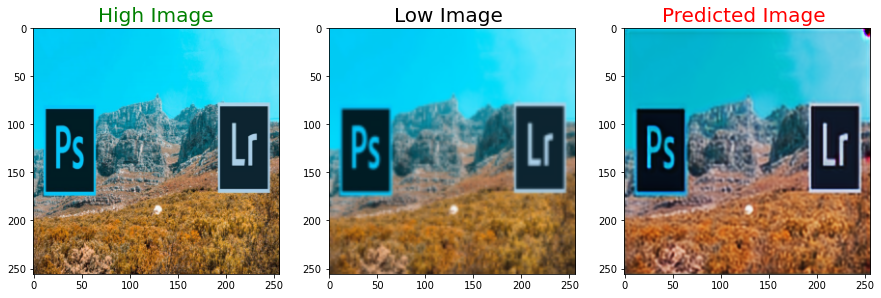

PSNR tf.Tensor(21.3858, shape=(), dtype=float32)


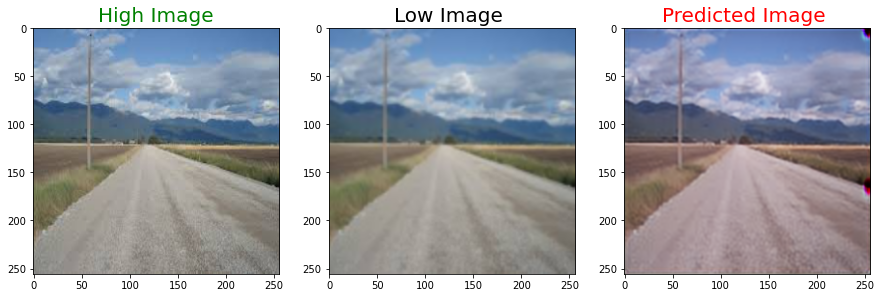

PSNR tf.Tensor(28.488659, shape=(), dtype=float32)


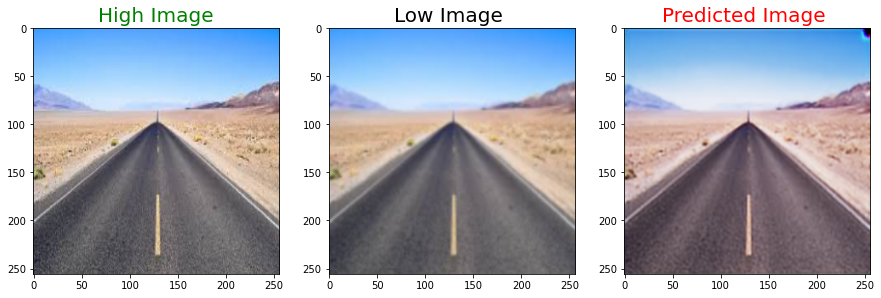

PSNR tf.Tensor(26.470108, shape=(), dtype=float32)


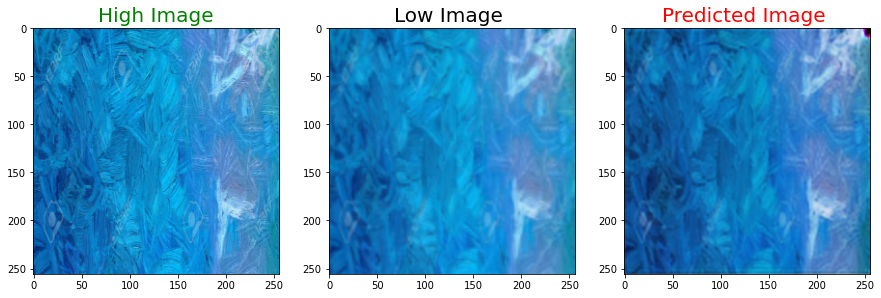

PSNR tf.Tensor(22.961288, shape=(), dtype=float32)


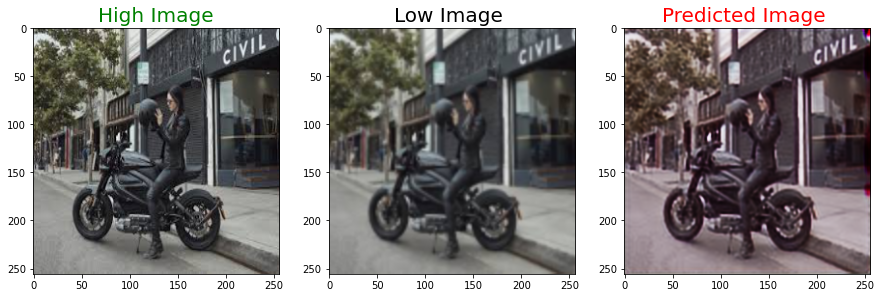

PSNR tf.Tensor(25.584652, shape=(), dtype=float32)


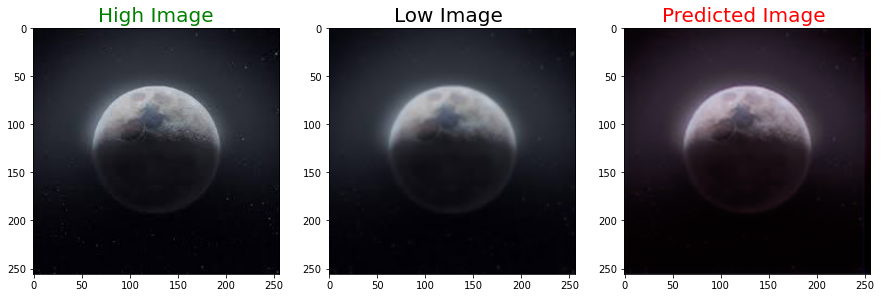

PSNR tf.Tensor(32.13741, shape=(), dtype=float32)


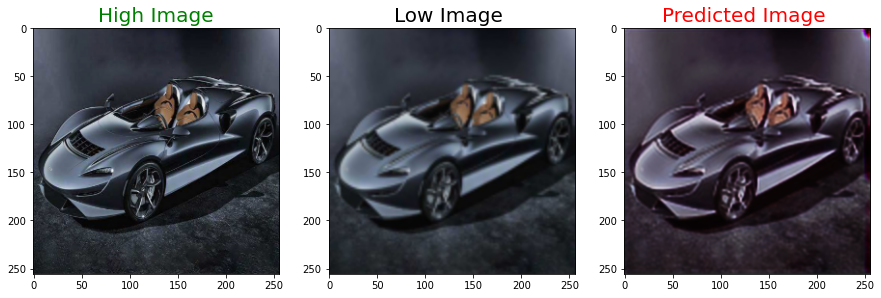

PSNR tf.Tensor(26.045639, shape=(), dtype=float32)


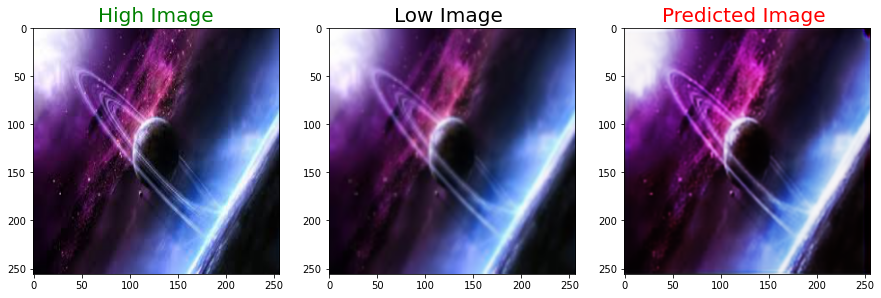

PSNR tf.Tensor(27.40285, shape=(), dtype=float32)


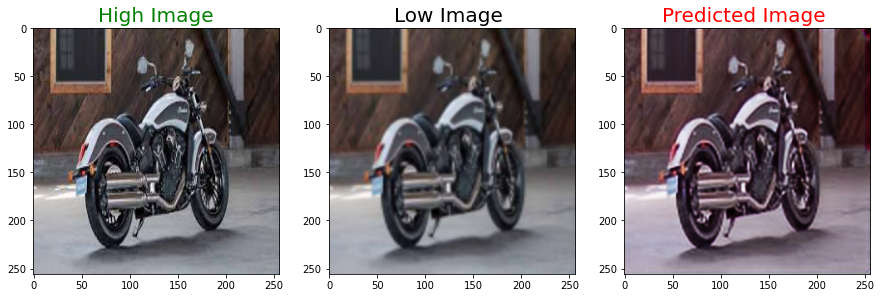

PSNR tf.Tensor(26.168697, shape=(), dtype=float32)


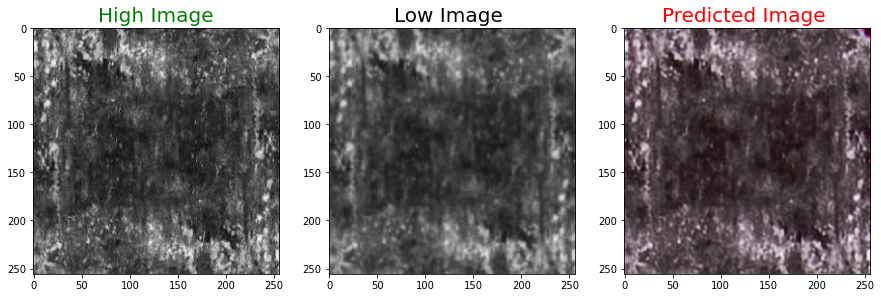

PSNR tf.Tensor(26.302273, shape=(), dtype=float32)


In [11]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(5,15):
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)
    print('PSNR', PSNR(test_high_image[i],predicted))

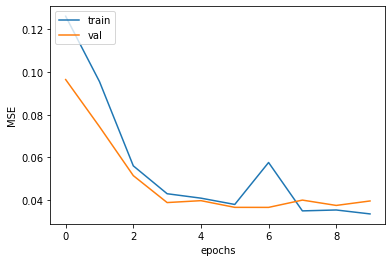

In [12]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend(['train','val'],loc = "upper left")
plt.show()

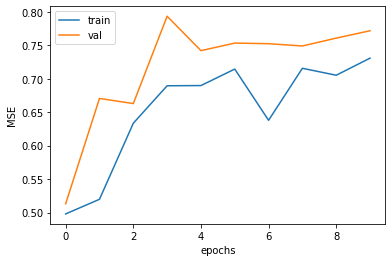

In [13]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend(['train','val'],loc = "upper left")
plt.show()